#### Import Modules

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame
from datetime import datetime, timedelta
from tqdm import tqdm
from multiprocessing import Pool, cpu_count

# Dask
import dask.dataframe as dd
from dask import delayed, compute
from dask.diagnostics import ProgressBar
# ProgressBar().register()


# Set the warning filter to 'ignore' to suppress all warnings
import warnings
# warnings.filterwarnings('ignore')

#### Import Data

In [2]:
file1 = pd.read_csv('../data/raw/File1.txt', header=None, sep=' ', names=['MeterID', 'codeDateTime', 'kWh'])


In [3]:
file_1 = file1.copy()

In [4]:
file_1.head()

,MeterID,codeDateTime,kWh
0,1392,19503,0.140
1,1392,19504,0.138
2,1392,19505,0.140
3,1392,19506,0.145
4,1392,19507,0.145


In [5]:
file_1['MeterID'].nunique()

1000

In [6]:
def code_to_datetime(code):
    if len(str(code)) != 5:
        raise ValueError("Input code must be a 5-digit integer.")

    day_code = int(str(code)[:3])
    time_code = int(str(code)[3:5])

    # Calculate the date
    base_date = datetime(2009, 1, 1)
    delta = timedelta(days=day_code)
    target_date = base_date + delta

    # Calculate the time
    hours = (time_code) // 2
    minutes = 30 * (time_code % 2)

    target_time = timedelta(hours=hours, minutes=minutes)

    # Combine the date and time to create the datetime object
    result_datetime = target_date + target_time

    return result_datetime

In [13]:
# Use tqdm to track progress
tqdm.pandas(desc="Converting")

# Apply the conversion function to the 'code' column
file_1['DateTime'] = file_1['codeDateTime'].progress_apply(code_to_datetime)
file_1.drop(columns=['codeDateTime'], inplace=True)

Converting: 100%|██████████| 24465838/24465838 [00:43<00:00, 560934.01it/s]


In [14]:
file_1.head(20)

,MeterID,kWh,DateTime
0,1392,0.140,2009-07-15 01:30:00
1,1392,0.138,2009-07-15 02:00:00
2,1392,0.140,2009-07-15 02:30:00
3,1392,0.145,2009-07-15 03:00:00
4,1392,0.145,2009-07-15 03:30:00
5,1392,0.157,2009-07-15 00:30:00
6,1392,0.144,2009-07-15 01:00:00
7,1392,0.128,2009-07-17 12:00:00
8,1392,0.142,2009-07-17 12:30:00
9,1392,0.145,2009-07-17 13:00:00


In [18]:
file_1.dtypes

MeterID              int64
kWh                float64
DateTime    datetime64[ns]
dtype: object

In [2]:
ddd = pd.read_csv('../data/interim/transformed_File1.txt', parse_dates=['DateTime'])

In [3]:
ddd.dtypes

MeterID              int64
kWh                float64
DateTime    datetime64[ns]
dtype: object

In [4]:
ddd.isna().sum()

MeterID     0
kWh         0
DateTime    0
dtype: int64

In [5]:
cpu_count()

16

In [9]:
def group_by_meter_id_dask(df):
    # logger.info("Grouping data by MeterID")
    try:
        # Get the number of cores
        cores = int(cpu_count() * 0.75)
        # Create a Dask DataFrame from the Pandas DataFrame
        dask_df = dd.from_pandas(df, npartitions=cores)  # You can adjust the number of partitions as needed

        # Get unique datetimes
        unique_datetimes = dask_df['DateTime'].unique().compute()
        meter_ids = dask_df['MeterID'].unique().compute()

        # Scatter the Dask DataFrame ahead of time
        dask_df = dask_df.repartition(npartitions=cores)  # You can adjust the number of partitions as needed

        # Create a list of futures for the results
        results = []

        # Define a function to process a single meter ID
        @delayed
        def process_meter(meter_id):
            meter_data = dask_df[dask_df['MeterID'] == meter_id]

            # Perform the required operations and return the result
            result = meter_data.groupby('DateTime')['kWh'].first().compute()
            result = result.reindex(unique_datetimes, fill_value=np.nan)
            return result

        # Use Dask's delayed function for parallel processing
        with ProgressBar():
            futures = [process_meter(meter_id) for meter_id in meter_ids]
            results = compute(*futures, num_workers=cores)
        

        # Combine the results into a Pandas DataFrame
        new_df = pd.concat(results, axis=1)
        new_df.columns = meter_ids
        new_df.index = unique_datetimes
        new_df = new_df.sort_index()
        # logger.info("Data grouped by MeterID")
    except Exception as e:
        # logger.error(f"Failed to group data by MeterID: {e}")
        raise e

    return new_df

In [10]:
experimental_grouped_data = group_by_meter_id_dask(ddd)

[########################################] | 100% Completed | 34.23 s


In [31]:
experimental_grouped_data.iloc[:].head(36)

MeterID,1392,1951,1491,1194,1804,1048,1802,1287,1529,1463,...,1298,1408,1597,1924,1519,1114,1396,1253,1589,1358
DateTime,,,,,,,,,,,,,,,,,,,,,
2009-07-15 00:30:00,0.157,0.165,0.019,0.399,0.096,0.148,0.910,0.840,0.407,0.138,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-15 01:00:00,0.144,0.112,0.112,0.305,0.126,0.225,0.514,0.986,0.421,0.337,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-15 01:30:00,0.140,0.014,0.018,0.280,0.086,0.200,0.351,1.432,0.281,0.223,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-15 02:00:00,0.138,0.014,0.011,0.245,0.123,0.143,0.243,1.576,0.142,0.280,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-15 02:30:00,0.140,0.041,0.111,0.389,0.100,0.200,0.258,1.428,0.208,0.159,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-15 03:00:00,0.145,0.115,0.018,0.102,0.181,0.248,0.284,1.268,0.233,0.163,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-15 03:30:00,0.145,0.069,0.013,0.139,0.178,0.160,0.330,0.966,0.079,0.195,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-15 04:00:00,0.144,0.014,0.115,0.102,0.148,0.161,0.225,1.220,0.079,0.127,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-15 04:30:00,0.141,0.014,0.012,0.167,0.108,0.234,0.044,1.135,0.163,0.300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def group_by_meter_id(df):
    # Initialize an empty DataFrame with 'DateTime' as the index
    unique_datetimes = df['DateTime'].unique()
    new_df = pd.DataFrame(index=unique_datetimes)

    # Iterate through MeterIDs and populate the new DataFrame with progress tracking
    meter_ids = df['MeterID'].unique()
    for meter_id in tqdm(meter_ids, desc="Processing MeterIDs", unit=" MeterID"):
        meter_data = df[df['MeterID'] == meter_id]
        new_df[meter_id] = new_df.index.map(
            lambda dt: meter_data[meter_data['DateTime'] == dt]['kWh'].values[0] if len(meter_data[meter_data['DateTime'] == dt]['kWh']) > 0 else np.nan
        )

    # Reset the index of the new DataFrame
    new_df.reset_index(inplace=True)
    new_df.set_index('index', inplace=True)
    new_df.sort_index(inplace=True)

    return new_df

In [23]:
def group_by_meter_id(df):
    # Initialize an empty DataFrame with 'DateTime' as the index
    unique_datetimes = df['DateTime'].unique()
    new_df = pd.DataFrame(index=unique_datetimes)

    # Iterate through MeterIDs and populate the new DataFrame with progress tracking
    meter_ids = df['MeterID'].unique()
    for meter_id in tqdm(meter_ids, desc="Processing MeterIDs", unit=" MeterID"):
        meter_data = df[df['MeterID'] == meter_id]
        new_df[meter_id] = new_df.index.map(
            lambda dt: meter_data[meter_data['DateTime'] == dt]['kWh'].values[0] if len(meter_data[meter_data['DateTime'] == dt]['kWh']) > 0 else np.nan
        )

    # Reset the index of the new DataFrame
    new_df.reset_index(inplace=True)
    new_df.set_index('index', inplace=True)
    new_df.sort_index(inplace=True)

    return new_df

In [24]:
grouped_data = group_by_meter_id(ddd)

Processing MeterIDs:   0%|          | 5/1000 [00:36<2:02:42,  7.40s/ MeterID]


KeyboardInterrupt: 

In [37]:
grouped_data.head(36).sort_index()

NameError: name 'grouped_data' is not defined

In [32]:
grouped_data.iloc[:,:3].head()

,1392,1951,1491
index,,,
2009-07-15 01:30:00,0.140,0.014,0.018
2009-07-15 02:00:00,0.138,0.014,0.011
2009-07-15 02:30:00,0.140,0.041,0.111
2009-07-15 03:00:00,0.145,0.115,0.018
2009-07-15 03:30:00,0.145,0.069,0.013


In [49]:
grouped_data.to_csv('../data/interim/grouped_data.csv', index=True, header=True)

In [10]:
def loadRawData(self, filename: str | list[str]) -> DataFrame:
    if type(filename) == str:
        dataframe = pd.read_csv(self.raw_path+"/"+filename, 
                                header=None, sep=' ', 
                                names=['MeterID', 'codeDateTime', 'kWh'])
    else:
        dataframe = pd.DataFrame(columns=['MeterID', 'codeDateTime', 'kWh'])
        for file in filename:
            if len(dataframe)==0:
                dataframe = pd.read_csv(self.raw_path+"/"+file,
                                        header=None, sep=' ',
                                        names=['MeterID', 'codeDateTime', 'kWh'])
            else:    
                dataframe = pd.concat([dataframe, pd.read_csv(self.raw_path+"/"+file,
                                                        header=None, sep=' ',
                                                        names=['MeterID', 'codeDateTime', 'kWh'])], ignore_index=True)

    return dataframe

In [3]:
dataframe = pd.DataFrame(columns=['MeterID', 'codeDateTime', 'kWh'])
len(dataframe)

0

In [4]:
file1 = pd.read_csv('../data/raw/File1.txt', header=None, sep=' ', names=['MeterID', 'codeDateTime', 'kWh'])
file2 = pd.read_csv('../data/raw/File2.txt', header=None, sep=' ', names=['MeterID', 'codeDateTime', 'kWh'])


In [5]:
len(file1)

24465838

In [6]:
len(file2)

24507300

In [7]:
len(file1) + len(file2)

48973138

In [8]:
raw_path = '../data/raw'
combined_file = loadRawData(raw_path=raw_path, filename= ['File1.txt', 'File2.txt'])

In [9]:
assert len(combined_file) == len(file1) + len(file2)

In [14]:
def scan_directory(raw_path, extension: str) -> list:
    """Check `raw_path` directory and return list of files with
    specified extension

    Args:
        extension (str): extension type to be searched for e.g. ".txt"

    Returns:
        list: strings of file names with specified extension
    """
    directory = raw_path    
    files: list = []
    for filename in os.listdir(directory):
        if filename.endswith(extension):
            files.append(filename)
    files.sort()
    return files

In [15]:
scan_directory(raw_path, '.txt')

['File1.txt', 'File2.txt', 'File3.txt', 'File4.txt', 'File5.txt', 'File6.txt']

In [1]:
'File1.txt'[:-4]

'File1'

In [1]:
int(17 * 0.75)

12

In [32]:
def loadData(directory: str, filename: str | list[str], sep=' ', names: list[str]=['MeterID', 'codeDateTime', 'kWh']) -> DataFrame:
    if type(filename) == str:
        # logger.info(f"Loading {filename}")
        try:
            if type(names)==list:
                dataframe = pd.read_csv(directory+"/"+filename, 
                                         sep=sep, 
                                        names=names)
            else:
                dataframe = pd.read_csv(directory+"/"+filename, sep=sep)
            # logger.info(f"Loaded {len(dataframe)} rows from {filename}")
        except Exception as e:
            # logger.error(f"Failed to load {filename}: {e}")
            raise e

        
    else:
        # logger.info(f"Loading files {filename}")
        try:
            dataframe = pd.DataFrame(columns=names)
            total_rows = 0
            if type(names)==list:
                for file in filename:
                    if len(dataframe)==0:
                        dataframe = pd.read_csv(directory+"/"+file,
                                                 sep=sep,
                                                names=names)
                        total_rows += len(dataframe)
                        # logger.info(f"Loaded {len(dataframe)} rows from {file}")
                    else:    
                        dataframe = pd.concat([dataframe, pd.read_csv(directory+"/"+file,
                                                                 sep=sep,
                                                                names=names)],
                                                                ignore_index=True)
                        total_rows += len(dataframe)
                        # logger.info(f"Loaded {len(dataframe)} rows from {file}")
            else:
                for file in filename:
                    if len(dataframe)==0:
                        dataframe = pd.read_csv(directory+"/"+file, sep=sep)
                        total_rows += len(dataframe)
                        # logger.info(f"Loaded {len(dataframe)} rows from {file}")
                    else:    
                        dataframe = pd.concat([dataframe, pd.read_csv(directory+"/"+file, sep=sep)],
                                                ignore_index=True)
                        total_rows += len(dataframe)
            # logger.info(f"Loaded {total_rows} rows from files{filename}")
        except Exception as e:
            # logger.error(f"Failed to load files {filename}: {e}")
            raise e

    return dataframe

In [33]:
qqq = loadData('../data/raw/', 'File1.txt')

In [34]:
qqq.head()

,1392,19503,0.14
0,1392,19504,0.138
1,1392,19505,0.140
2,1392,19506,0.145
3,1392,19507,0.145
4,1392,19501,0.157


In [39]:
ggg = pd.read_csv('../data/interim/grouped_data_File1.csv', parse_dates=['index'], index_col='index')
ggg.columns.rename('MeterID', inplace=True)
ggg.index.rename('DateTime', inplace=True)

In [41]:
ggg.head()

MeterID,1392,1951,1491,1194,1804,1048,1802,1287,1529,1463,...,1298,1408,1597,1924,1519,1114,1396,1253,1589,1358
DateTime,,,,,,,,,,,,,,,,,,,,,
2009-07-15 00:30:00,0.157,0.165,0.019,0.399,0.096,0.148,0.910,0.840,0.407,0.138,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-15 01:00:00,0.144,0.112,0.112,0.305,0.126,0.225,0.514,0.986,0.421,0.337,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-15 01:30:00,0.140,0.014,0.018,0.280,0.086,0.200,0.351,1.432,0.281,0.223,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-15 02:00:00,0.138,0.014,0.011,0.245,0.123,0.143,0.243,1.576,0.142,0.280,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-15 02:30:00,0.140,0.041,0.111,0.389,0.100,0.200,0.258,1.428,0.208,0.159,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
assert experimental_grouped_data == ggg

ValueError: Can only compare identically-labeled (both index and columns) DataFrame objects

In [38]:
ggg.iloc[:,0].head(36)

DateTime
2009-07-15 00:30:00    0.157
2009-07-15 01:00:00    0.144
2009-07-15 01:30:00    0.140
2009-07-15 02:00:00    0.138
2009-07-15 02:30:00    0.140
2009-07-15 03:00:00    0.145
2009-07-15 03:30:00    0.145
2009-07-15 04:00:00    0.144
2009-07-15 04:30:00    0.141
2009-07-15 05:00:00    0.142
2009-07-15 05:30:00    0.144
2009-07-15 06:00:00    0.148
2009-07-15 06:30:00    0.146
2009-07-15 07:00:00    0.135
2009-07-15 07:30:00    0.136
2009-07-15 08:00:00    1.957
2009-07-15 08:30:00    0.136
2009-07-15 09:00:00    0.134
2009-07-15 09:30:00    0.130
2009-07-15 10:00:00    0.135
2009-07-15 10:30:00    0.147
2009-07-15 11:00:00    0.144
2009-07-15 11:30:00    0.131
2009-07-15 12:00:00    0.165
2009-07-15 12:30:00    0.207
2009-07-15 13:00:00    0.140
2009-07-15 13:30:00    0.139
2009-07-15 14:00:00    0.139
2009-07-15 14:30:00    0.140
2009-07-15 15:00:00    0.135
2009-07-15 15:30:00    0.149
2009-07-15 16:00:00    0.150
2009-07-15 16:30:00    0.150
2009-07-15 17:00:00    0.175
2009-

In [4]:
ggg.head()

,1392,1951,1491,1194,1804,1048,1802,1287,1529,1463,...,1298,1408,1597,1924,1519,1114,1396,1253,1589,1358
index,,,,,,,,,,,,,,,,,,,,,
2009-07-15 01:30:00,0.140,0.014,0.018,0.280,0.086,0.200,0.351,1.432,0.281,0.223,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-15 02:00:00,0.138,0.014,0.011,0.245,0.123,0.143,0.243,1.576,0.142,0.280,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-15 02:30:00,0.140,0.041,0.111,0.389,0.100,0.200,0.258,1.428,0.208,0.159,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-15 03:00:00,0.145,0.115,0.018,0.102,0.181,0.248,0.284,1.268,0.233,0.163,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-15 03:30:00,0.145,0.069,0.013,0.139,0.178,0.160,0.330,0.966,0.079,0.195,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
mmm = pd.concat([ggg, ggg], axis=1)

In [6]:
mmm.head()

,1392,1951,1491,1194,1804,1048,1802,1287,1529,1463,...,1298,1408,1597,1924,1519,1114,1396,1253,1589,1358
index,,,,,,,,,,,,,,,,,,,,,
2009-07-15 01:30:00,0.140,0.014,0.018,0.280,0.086,0.200,0.351,1.432,0.281,0.223,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-15 02:00:00,0.138,0.014,0.011,0.245,0.123,0.143,0.243,1.576,0.142,0.280,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-15 02:30:00,0.140,0.041,0.111,0.389,0.100,0.200,0.258,1.428,0.208,0.159,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-15 03:00:00,0.145,0.115,0.018,0.102,0.181,0.248,0.284,1.268,0.233,0.163,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-15 03:30:00,0.145,0.069,0.013,0.139,0.178,0.160,0.330,0.966,0.079,0.195,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
mmm['1392']

index
2009-07-15 01:30:00    0.140
2009-07-15 02:00:00    0.138
2009-07-15 02:30:00    0.140
2009-07-15 03:00:00    0.145
2009-07-15 03:30:00    0.145
                       ...  
2011-01-01 22:00:00      NaN
2011-01-01 22:30:00      NaN
2011-01-01 23:00:00      NaN
2011-01-01 23:30:00      NaN
2011-01-02 00:00:00      NaN
Name: 1392, Length: 25726, dtype: float64

In [21]:
mmm = mmm.loc[:,~mmm.columns.duplicated()] # type: ignore

In [22]:
mmm.columns

Index(['1392', '1951', '1491', '1194', '1804', '1048', '1802', '1287', '1529',
       '1463',
       ...
       '1298', '1408', '1597', '1924', '1519', '1114', '1396', '1253', '1589',
       '1358'],
      dtype='object', length=1000)

#### Explore Concatenated Data

In [2]:
concat_data = pd.read_csv('../data/interim/concatenated_data.csv', parse_dates=['index'], index_col='index')

In [3]:
concat_data.iloc[:,1000:2000].head()

,2113,2549,2946,2003,2092,2342,2535,2480,2578,2229,...,2483,2326,2642,2783,2425,2368,2660,2155,3823,3533
index,,,,,,,,,,,,,,,,,,,,,
2009-07-15 00:30:00,0.189,0.139,0.374,0.243,0.190,0.222,0.118,0.144,0.013,0.816,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.327,0.123
2009-07-15 01:00:00,0.139,0.139,0.079,0.230,0.087,0.221,0.120,0.126,0.013,0.497,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.323,0.000
2009-07-15 01:30:00,0.149,0.455,0.099,0.150,0.034,0.150,0.042,0.133,0.013,0.442,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.288,0.000
2009-07-15 02:00:00,0.039,0.136,0.051,0.150,0.113,0.180,0.046,0.145,0.013,0.228,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.344,0.176
2009-07-15 02:30:00,0.039,0.141,0.057,0.228,0.034,0.244,0.123,0.133,0.013,0.215,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.274,0.365


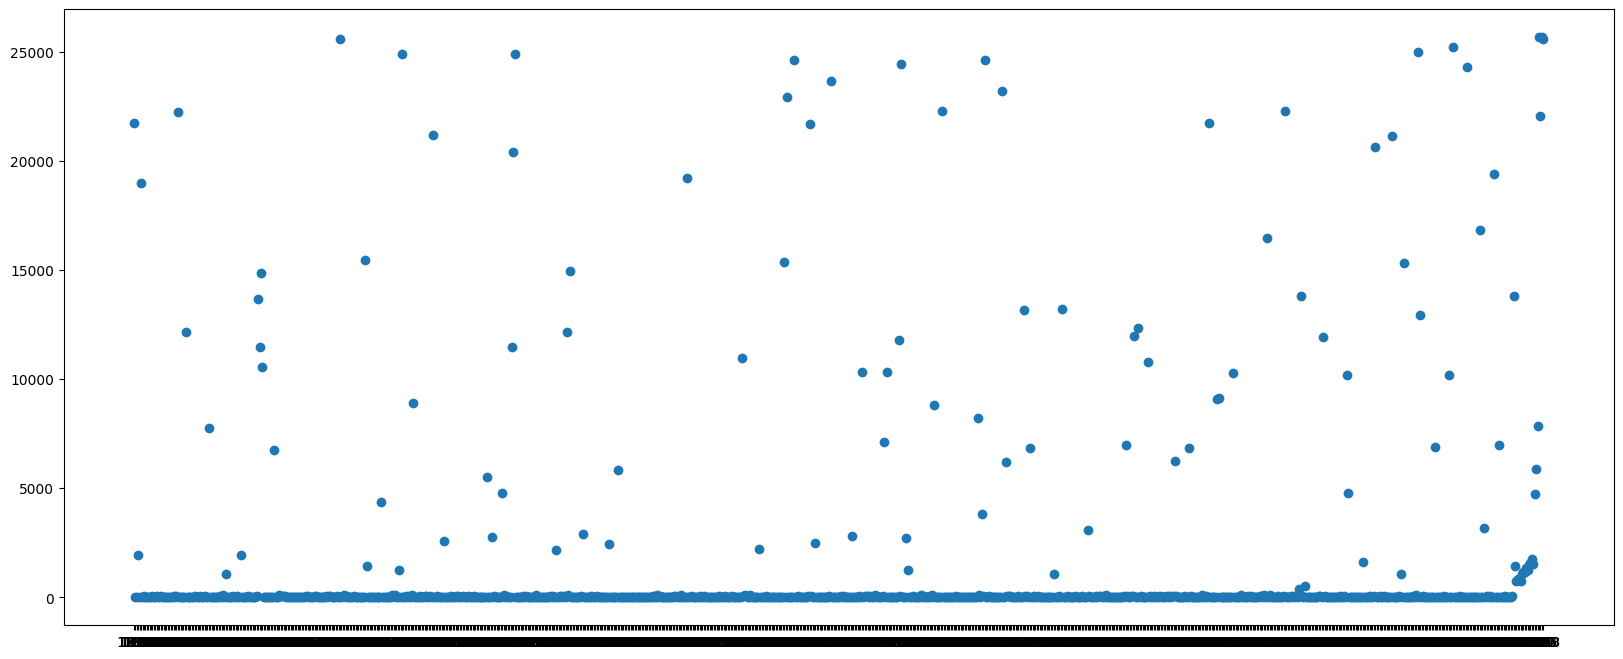

In [4]:
# Plot missing values
plt.figure(figsize=(20, 8))
plt.scatter(concat_data.columns[:1000], concat_data.isna().sum()[:1000])

In [5]:
# Load label data
label_data = pd.read_excel('../data/raw/CER_Electricity_Documentation/SME and Residential allocations.xlsx',
                           sheet_name='Sheet1',
                           usecols=['ID', 'Code', 'Residential - Tariff allocation', 'Residential - stimulus allocation', 'SME allocation']
                        )

In [6]:
label_data.head()

,ID,Code,Residential - Tariff allocation,Residential - stimulus allocation,SME allocation
0,1000,3,NaN,NaN,NaN
1,1001,3,NaN,NaN,NaN
2,1002,1,E,E,NaN
3,1003,1,A,4,NaN
4,1004,1,A,2,NaN


In [7]:
# Filter out control Meters
control_meters = []
for i in range(len(label_data)):
    if label_data['Residential - Tariff allocation'][i] == 'E' or\
    label_data['Residential - stimulus allocation'][i] == 'E' or\
    label_data['SME allocation'][i] == 'C':
        control_meters.append(str(label_data['ID'][i]))


In [8]:
len(control_meters)

1126

In [9]:
all_meters = concat_data.columns.to_list()
len(all_meters)

6435

In [10]:
valid_meters = set(all_meters) ^ set(control_meters)

In [11]:
len(valid_meters)

5309

In [12]:
# Filter out control Meters from concatenated data
filtered_data = concat_data.drop(columns=control_meters)

In [ ]:
def filterData(raw_path: str, dataframe: DataFrame):
    # Load filter codes data
    label_data = pd.read_excel(f'{raw_path}/CER_Electricity_Documentation/SME and Residential allocations.xlsx',
                        sheet_name='Sheet1',
                        usecols=['ID', 'Code', 'Residential - Tariff allocation', 'Residential - stimulus allocation', 'SME allocation']
                    )
    
    # Get control meters
    control_meters = []
    for i in range(len(label_data)):
        if label_data['Residential - Tariff allocation'][i] == 'E' or\
        label_data['Residential - stimulus allocation'][i] == 'E' or\
        label_data['SME allocation'][i] == 'C':
            control_meters.append(str(label_data['ID'][i]))

    # Filter out control Meters from concatenated data
    filtered_data = dataframe.drop(columns=control_meters)
    return filtered_data

In [13]:
len(filtered_data.columns)

5309

In [14]:
filtered_data.head()

,1392,1951,1491,1194,1048,1802,1287,1529,1860,1334,...,7212,7052,7158,6891,7174,6114,7426,6099,6589,6862
index,,,,,,,,,,,,,,,,,,,,,
2009-07-15 00:30:00,0.157,0.165,0.019,0.399,0.148,0.910,0.840,0.407,0.156,0.165,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-15 01:00:00,0.144,0.112,0.112,0.305,0.225,0.514,0.986,0.421,0.172,0.230,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-15 01:30:00,0.140,0.014,0.018,0.280,0.200,0.351,1.432,0.281,0.220,0.098,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-15 02:00:00,0.138,0.014,0.011,0.245,0.143,0.243,1.576,0.142,0.269,0.306,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-15 02:30:00,0.140,0.041,0.111,0.389,0.200,0.258,1.428,0.208,0.194,0.168,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
len(filtered_data)

25726

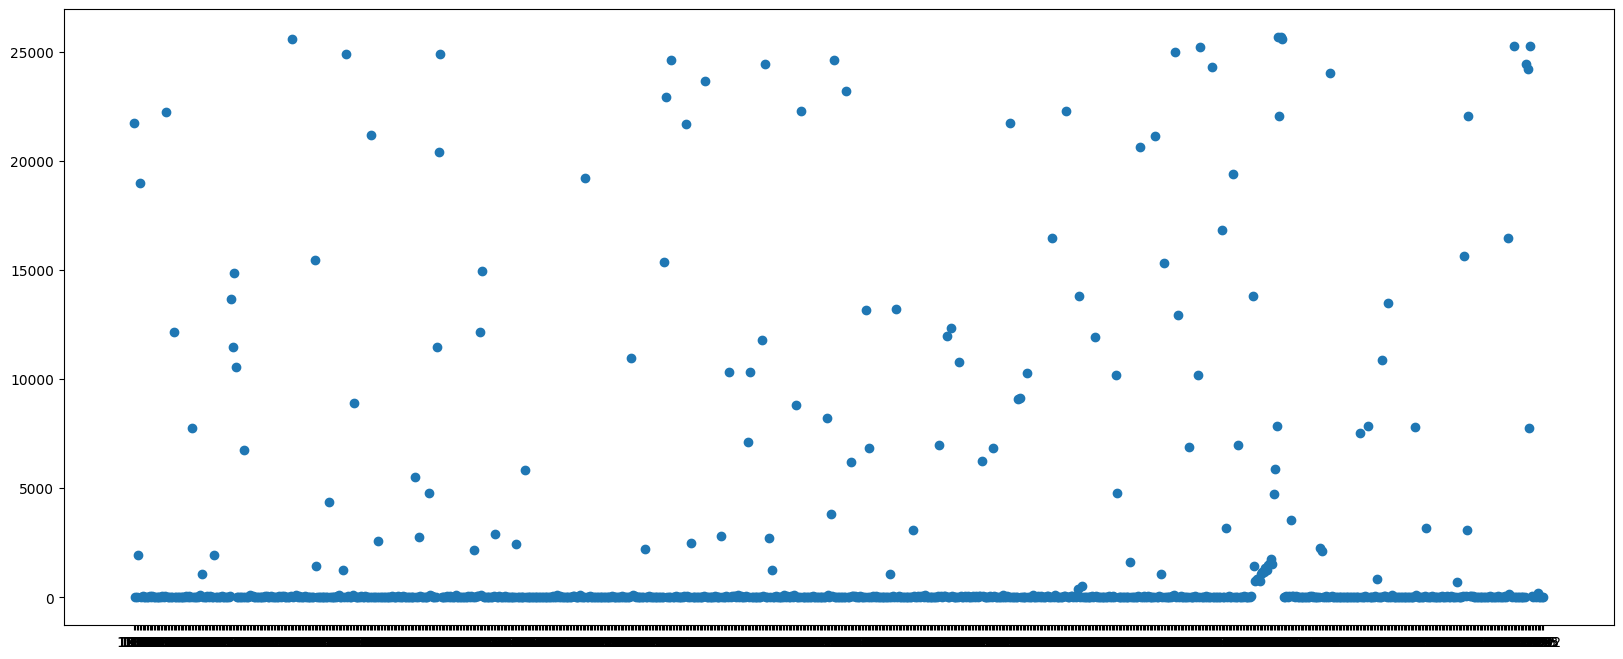

In [16]:
# Plot missing values
plt.figure(figsize=(20, 8))
plt.scatter(filtered_data.columns[:1000], filtered_data.isna().sum()[:1000])

##### Solve for Missing values

In [17]:
cols_with_na = 0
cols = []
for i in filtered_data.columns:
    if filtered_data[i].isna().sum() > len(filtered_data)*0.20:
        cols_with_na += 1
        cols.append(i)

print(cols_with_na)
print("Perentage:",cols_with_na/len(filtered_data.columns)*100)
print(cols)

469
Perentage: 8.834055377660576
['1392', '1048', '1957', '1320', '1106', '1419', '1467', '1173', '1841', '1190', '1489', '1714', '1256', '1572', '1960', '1908', '1813', '1089', '1901', '1310', '1785', '1513', '1739', '1825', '1662', '1579', '1040', '1621', '1158', '1568', '1470', '1552', '1913', '1282', '1490', '1245', '1434', '1937', '1237', '1911', '1272', '1206', '1956', '1131', '1792', '1705', '1357', '1308', '1289', '1449', '1620', '1915', '1211', '1696', '1135', '1605', '1038', '1849', '1509', '1012', '1738', '1193', '1771', '1826', '1958', '1805', '1103', '1313', '1601', '1866', '1703', '1519', '1114', '1396', '1253', '1589', '1358', '2274', '2677', '2385', '2961', '2419', '2775', '2339', '2750', '2136', '2517', '2137', '2569', '2322', '2659', '2563', '2089', '2788', '2378', '2445', '2134', '2806', '2538', '2847', '2063', '2273', '2949', '2920', '2179', '2766', '2651', '2948', '2227', '2726', '2921', '2558', '2454', '2361', '2362', '2831', '2866', '2132', '2190', '2290', '2615'

In [ ]:
def removeMissingValues(dataframe: DataFrame, threshold = 0.20) -> DataFrame:
    cols = []
    for i in dataframe.columns:
        if dataframe[i].isna().sum() > len(dataframe)*threshold:
            cols.append(i)
    dataframe = dataframe.drop(columns=cols)
    return dataframe

The data will be aggregated accross all columns, so data points with Na values will disappear in the process

In [18]:
def sumAllRows(dataframe: pd.DataFrame) -> pd.DataFrame:

    # Sum all rows along axis 1
    row_sums = dataframe.sum(axis=1)

    # Create a new DataFrame with only the row sums
    result_df = pd.DataFrame({'kWh': row_sums})
    
    return result_df

In [19]:
summed_filtered_data = sumAllRows(filtered_data)

In [20]:
summed_filtered_data.describe()

,kWh
count,25726.000000
mean,3468.073431
std,1284.857336
min,1312.871000
25%,2244.193750
50%,3583.481000
75%,4336.985750
max,7771.284000


In [21]:
summed_filtered_data.mode()

,kWh
0,1385.806
1,1415.133
2,1417.268
3,1466.096
4,1575.920
...,...
59,4570.626
60,4620.916
61,4917.364
62,4942.503


In [22]:
filtered_data_no_mv = filtered_data.drop(columns=cols)
summed_filtered_data_no_mv = sumAllRows(filtered_data_no_mv)
summed_filtered_data_no_mv.describe()

,kWh
count,25726.000000
mean,3231.488473
std,1192.487423
min,1270.480000
25%,2081.443500
50%,3397.804000
75%,3962.087500
max,7158.690000


In [23]:
# Fill missing values column by column
partitions = 4
filled_data1 = dd.from_pandas(filtered_data_no_mv.iloc[:, :500], npartitions=partitions)
filled_data2 = dd.from_pandas(filtered_data_no_mv.iloc[:, 500:1000], npartitions=partitions)
filled_data3 = dd.from_pandas(filtered_data_no_mv.iloc[:, 1000:1500], npartitions=partitions)
filled_data4 = dd.from_pandas(filtered_data_no_mv.iloc[:, 1500:2000], npartitions=partitions)
filled_data5 = dd.from_pandas(filtered_data_no_mv.iloc[:, 2000:2500], npartitions=partitions)
filled_data6 = dd.from_pandas(filtered_data_no_mv.iloc[:, 2500:3000], npartitions=partitions)
filled_data7 = dd.from_pandas(filtered_data_no_mv.iloc[:, 3000:3500], npartitions=partitions)
filled_data8 = dd.from_pandas(filtered_data_no_mv.iloc[:, 3500:4000], npartitions=partitions)
filled_data9 = dd.from_pandas(filtered_data_no_mv.iloc[:, 4000:4500], npartitions=partitions)
filled_data10 = dd.from_pandas(filtered_data_no_mv.iloc[:, 4500:], npartitions=partitions)
# filled_data11 = dd.from_pandas(filtered_data_no_mv.iloc[:, 5000:5500], npartitions=10)
# filled_data12 = dd.from_pandas(filtered_data_no_mv.iloc[:, 5500:], npartitions=10)


filled_data1 = filled_data1.ffill().compute(num_workers=12)
filled_data2 = filled_data2.ffill().compute(num_workers=12)
filled_data3 = filled_data3.ffill().compute(num_workers=12)
filled_data4 = filled_data4.ffill().compute(num_workers=12)
filled_data5 = filled_data5.ffill().compute(num_workers=12)
filled_data6 = filled_data6.ffill().compute(num_workers=12)
filled_data7 = filled_data7.ffill().compute(num_workers=12)
filled_data8 = filled_data8.ffill().compute(num_workers=12)
filled_data9 = filled_data9.ffill().compute(num_workers=12)
filled_data10 = filled_data10.ffill().compute(num_workers=12)

# Check stats
summed_filled = [filled_data1, filled_data2, filled_data3, filled_data4, filled_data5,
                 filled_data6, filled_data7, filled_data8, filled_data9, filled_data10]
data_list = []
for i in summed_filled:
    summed_filled_data = sumAllRows(i)
    data_list.append(summed_filled_data)

# Concatenate all data
all_data_concat = pd.concat(data_list, axis=1, ignore_index=True)
all_data_concat = sumAllRows(all_data_concat)
all_data_concat.describe()

,kWh
count,25726.000000
mean,3247.039804
std,1197.674921
min,1270.480000
25%,2104.944500
50%,3404.224000
75%,3974.823250
max,7158.885000


Summing up the data after removing columns with missing values more than 20% is sufficient, as filling up missing values is computationally expensive and only  
improves stats by margin of error values

In [24]:
list(range(1, 11))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]